<a href="https://colab.research.google.com/github/rondinell/Intelig-ncia-Artificial/blob/main/programalivroanalistaderiscopronto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✓ Bibliotecas importadas com sucesso.

--- 1. Baixando e preparando os dados ---
✓ 1352 registros preparados para os modelos.

--- 2. Treinando o Modelo de Detecção de Anomalias (Autoencoder) ---
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
✓ Modelo de anomalia treinado. Limiar de anomalia definido em: 0.0000
Total de anomalias detectadas: 28 dias.

--- 3. Treinando o Modelo de Previsão de Direção (LSTM) ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✓ Modelo LSTM treinado.

--- 4. Combinando as Previsões e Gerando Sinais Finais ---
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step

--- Análise dos Sinais Combinados (Últimos 30 dias do teste) ---
Price           Close Realmente_Subiu LSTM_Prob_Subir Is_Anomaly  \
Ticker       BBAS3.SA                                              
Date                                                               
2025-06-13  21.590000               1        0.554232          0   
2025-06-16  21.980000               0        0.554399          0   
2025-06-17  21.900000               0        0.554578          0   
2025-06-18  21.809999               0        0.554718          0   
2025-06-20  21.350000               0        0.555086          0   
2025-06-23  21.090000               1        0.555647          0   
2025-06-24  21.440001               0        0.556239          0   
2025-06-25  21.260000               1        0.556531          0   
2025-06-26  21.600000               1        0.557033          

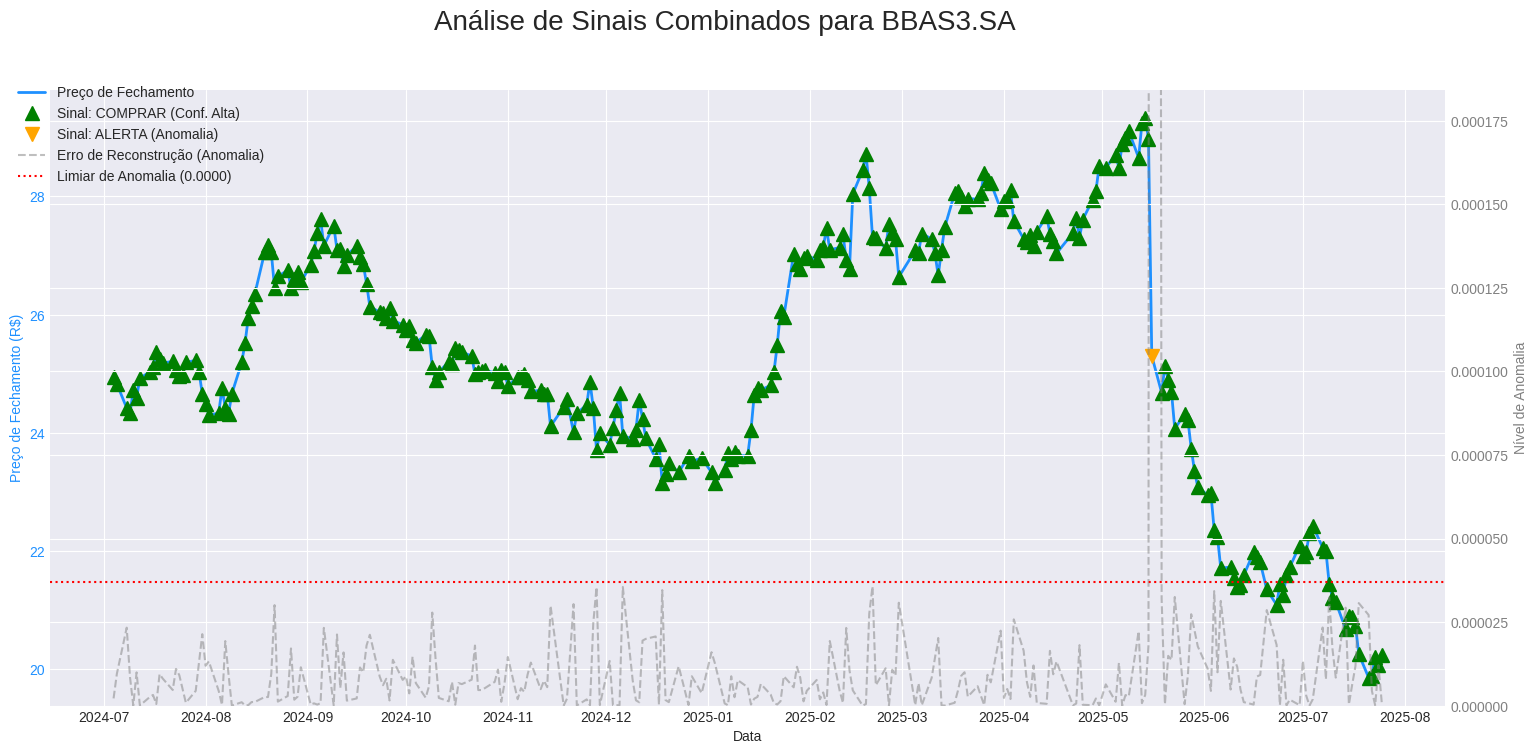

In [25]:
# ===================================================================================
# IA NOS INVESTIMENTOS: ESTUDO DE CASO AVANÇADO
# Combinando uma LSTM (Estrategista) com um Autoencoder (Analista de Risco)
# Autor: Rondinelli Alves de Andrade, com assistência de IA
# ===================================================================================

# --- Passo 0: Instalação e Importação das Bibliotecas ---
# Se estiver no Google Colab, a 'ta' pode precisar de instalação
!pip install ta --quiet

import yfinance as yf
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import ta
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates # Import mdates

print("✓ Bibliotecas importadas com sucesso.")

# Configurações para reprodutibilidade
np.random.seed(42)
tf.random.set_seed(42)


# ============================================================
# 1. OBTER E PREPARAR OS DADOS
# ============================================================
print("\n--- 1. Baixando e preparando os dados ---")
TICKER = 'BBAS3.SA' # Vamos usar a bANCO DO bRASIL como exemplo
df = yf.download(TICKER, start="2020-01-01", end=datetime.now().strftime("%Y-%m-%d"), progress=False, auto_adjust=True)
if df.empty:
    raise ValueError(f"Nenhum dado retornado para o ticker {TICKER}.")

# Criar Indicadores Técnicos para a LSTM
# Access the 'Close' data explicitly as a Series
close_prices = df['Close'].squeeze()

df['SMA_14'] = ta.trend.sma_indicator(close_prices, window=14)
df['RSI'] = ta.momentum.rsi(close_prices, window=14)
macd = ta.trend.MACD(close_prices)
df['MACD'] = macd.macd()
df['MACD_Signal'] = macd.macd_signal()

# Criar o Alvo para a LSTM (classificação: 1 si o preço de amanhã subiu, 0 caso contrário)
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)


# Criar os Retornos Diários para o Autoencoder
df['Return'] = df['Close'].pct_change()

# Limpar dados (remover linhas com NaN gerados pelos indicadores e retornos)
df.dropna(inplace=True)
print(f"✓ {len(df)} registros preparados para os modelos.")


# ===================================================================================
# 2. MODELO 1: AUTOENCODER PARA DETECÇÃO DE ANOMALIAS (O Analista de Risco)
# ===================================================================================
print("\n--- 2. Treinando o Modelo de Detecção de Anomalias (Autoencoder) ---")

# Preparar os dados de retorno
returns_data = df[['Return']].values
scaler_ae = MinMaxScaler(feature_range=(0, 1))
scaled_returns = scaler_ae.fit_transform(returns_data)

# Construir o Autoencoder
input_dim = scaled_returns.shape[1]
encoding_dim = 1
input_layer = Input(shape=(input_dim,))
encoder = Dense(8, activation="relu")(input_layer)
encoder = Dense(4, activation="relu")(encoder)
encoder_output = Dense(encoding_dim, activation="relu")(encoder)
decoder = Dense(4, activation="relu")(encoder_output)
decoder = Dense(8, activation="relu")(decoder)
decoder_output = Dense(input_dim, activation="sigmoid")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder_output)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Treinar o Autoencoder
autoencoder.fit(scaled_returns, scaled_returns,
              epochs=50,
              batch_size=32,
              shuffle=True,
              validation_split=0.2,
              verbose=0) # verbose=0 para não poluir a saída

# Detectar anomalias
reconstructions = autoencoder.predict(scaled_returns)
reconstruction_error = np.mean(np.square(scaled_returns - reconstructions), axis=1)
df['Reconstruction_Error'] = reconstruction_error

# Definir um limiar para anomalia (ex: 98º percentil do erro)
anomaly_threshold = np.percentile(reconstruction_error, 98)
df['Is_Anomaly'] = (df['Reconstruction_Error'] > anomaly_threshold).astype(int)
print(f"✓ Modelo de anomalia treinado. Limiar de anomalia definido em: {anomaly_threshold:.4f}")
print(f"Total de anomalias detectadas: {df['Is_Anomaly'].sum()} dias.")


# ===================================================================================
# 3. MODELO 2: LSTM PARA PREVISÃO DE DIREÇÃO (O Estrategista)
# ===================================================================================
print("\n--- 3. Treinando o Modelo de Previsão de Direção (LSTM) ---")

# Preparar os dados para a LSTM
# Ensure all features are selected correctly, handling the multi-level column index
features_list = ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_14', 'RSI', 'MACD', 'MACD_Signal']
features = df[features_list].values
target = df['Target'].values


scaler_lstm = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_lstm.fit_transform(features)

# Criar sequências
SEQ_LENGTH = 30 # Usar os últimos 30 dias para prever o próximo
X, y = [], []
for i in range(SEQ_LENGTH, len(scaled_features)):
    X.append(scaled_features[i-SEQ_LENGTH:i, :])
    y.append(target[i])
X, y = np.array(X), np.array(y)

# Dividir em treino e teste (vamos usar os dados mais recentes para teste)
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Construir o modelo LSTM
model_lstm = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Treinar a LSTM
model_lstm.fit(X_train, y_train,
             epochs=100,
             batch_size=32,
             validation_split=0.2,
             callbacks=[early_stop],
             verbose=0)
print("✓ Modelo LSTM treinado.")


# ===================================================================================
# 4. A MÁGICA: COMBINANDO OS DOIS MODELOS E ANALISANDO OS RESULTADOS
# ===================================================================================
print("\n--- 4. Combinando as Previsões e Gerando Sinais Finais ---")

# Obter as previsões da LSTM para o conjunto de teste
predictions_proba = model_lstm.predict(X_test).flatten()
# Converter probabilidades em sinais (0 ou 1) usando um threshold padrão de 0.5
lstm_signals = (predictions_proba > 0.5).astype(int)

# Pegar os dados correspondentes ao período de teste
df_test = df.iloc[-len(X_test):].copy()
df_test['LSTM_Signal'] = lstm_signals
df_test['LSTM_Prob_Subir'] = predictions_proba

# Criar o Sinal Final com a "Dupla Verificação"
df_test['Sinal_Final'] = 'MANTER' # Começa com a decisão padrão
# Condição para Compra de Alta Confiança
buy_condition = (df_test['LSTM_Signal'] == 1) & (df_test['Is_Anomaly'] == 0)
df_test.loc[buy_condition, 'Sinal_Final'] = 'COMPRAR (Conf. Alta)'

# Condição para Alerta de Anomalia
anomaly_alert_condition = (df_test['LSTM_Signal'] == 1) & (df_test['Is_Anomaly'] == 1)
df_test.loc[anomaly_alert_condition, 'Sinal_Final'] = 'ALERTA (Anomalia)'

# Mostrar os resultados
print("\n--- Análise dos Sinais Combinados (Últimos 30 dias do teste) ---")
final_results = df_test[['Close', 'Target', 'LSTM_Prob_Subir', 'Is_Anomaly', 'Sinal_Final']].tail(30)
# Renomear 'Target' para maior clareza
final_results.rename(columns={'Target': 'Realmente_Subiu'}, inplace=True)

print(final_results)

# Avaliar a acurácia do sinal de "COMPRAR (Conf. Alta)"
sinais_compra_confiaveis = final_results[final_results['Sinal_Final'] == 'COMPRAR (Conf. Alta)']
if not sinais_compra_confiaveis.empty:
    acuracia_compra = accuracy_score(sinais_compra_confiaveis['Realmente_Subiu'], np.ones(len(sinais_compra_confiaveis)))
    print(f"\n- Dos {len(sinais_compra_confiaveis)} sinais 'COMPRAR (Conf. Alta)' gerados, a acuracia foi de: {acuracia_compra:.2%}")
else:
    print("\n- Nenhum sinal de 'COMPRAR (Conf. Alta)' foi gerado no período analisado.")

# Visualização Gráfica
plt.style.use('seaborn-v0_8-darkgrid')
fig, ax1 = plt.subplots(figsize=(18, 8))

# Gráfico de Preço
ax1.plot(df_test.index, df_test['Close'], label='Preço de Fechamento', color='dodgerblue', linewidth=2)
ax1.set_xlabel('Data')
ax1.set_ylabel('Preço de Fechamento (R$)', color='dodgerblue')
ax1.tick_params(axis='y', labelcolor='dodgerblue')

# Marcar Sinais de Compra (Alta Confiança)
buy_signals_dates = df_test[df_test['Sinal_Final'] == 'COMPRAR (Conf. Alta)'].index
ax1.plot(buy_signals_dates, df_test.loc[buy_signals_dates, 'Close'], '^', markersize=10, color='green', label='Sinal: COMPRAR (Conf. Alta)')

# Marcar Alertas de Anomalia
anomaly_alerts_dates = df_test[df_test['Sinal_Final'] == 'ALERTA (Anomalia)'].index
ax1.plot(anomaly_alerts_dates, df_test.loc[anomaly_alerts_dates, 'Close'], 'v', markersize=10, color='orange', label='Sinal: ALERTA (Anomalia)')

# Gráfico do Erro de Reconstrução (Anomalias) no eixo secundário
ax2 = ax1.twinx()
ax2.plot(df_test.index, df_test['Reconstruction_Error'], color='gray', linestyle='--', alpha=0.5, label='Erro de Reconstrução (Anomalia)')
ax2.axhline(y=anomaly_threshold, color='red', linestyle=':', label=f'Limiar de Anomalia ({anomaly_threshold:.4f})')
ax2.set_ylabel('Nível de Anomalia', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')
ax2.set_ylim(0, anomaly_threshold * 5) # Ajustar a escala para melhor visualização

# Limit the number of x-axis ticks
ax1.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=15))


# Legendas e Título
fig.suptitle(f'Análise de Sinais Combinados para {TICKER}', fontsize=20)
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.xticks(rotation=45) # Rotate x-axis labels
plt.show()